In [1]:
!pip install pymorphy2
!pip install pyLDAvis

In [4]:
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm import tqdm_notebook
import re
import pandas as pd
from nltk import ngrams
from collections import Counter
import gensim.corpora as corpora
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import operator
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with open("drive/MyDrive/inbox.json", "r") as f_:
  json_ = json.load(f_)

In [6]:
len(json_)

3843

In [7]:
docs = [doc["text"] for doc in json_]
docs = docs[:100]

In [8]:
#ungroup
ungrouped_docs = []

for doc in docs:
  if "-----Original Message-----" in doc:
    for elem in docs[0].split("-----Original Message-----"):
      try:
        ungrouped_docs.append(elem.split("С уважением,")[0].split("Subject")[1])
      except:
        ungrouped_docs.append(elem.split("С уважением,")[0])
  else:
    ungrouped_docs.append(doc)

In [9]:
mystop = ["mailto", "image", "http", "https", "конырёв", "белиловский", "курдюк",
          "булдашов", "белиловский", "уважение", "моб", "добрый", "день", "черток", "роман", "негго", "коллега", 
          "спасибо", "театральный", "тверской", "охотный", "январь", "декабрь", "крысан", "теренин", "салуесть",
          "деведёр", "седелевый", "варган", "лексутиный", "воротник"]

In [10]:
morph = MorphAnalyzer()
stop = set(stopwords.words('russian')+mystop)

In [11]:
def lemmatize_texts(texts):
    tokenized_text = []
    for text in tqdm_notebook(texts):
        prog = re.compile(r'[а-яa-z]+')
        tokens = prog.findall(str(text).lower())
        res=[morph.parse(token)[0].normal_form for token in tokens \
             if morph.parse(token)[0].normal_form not in stop \
             and len(morph.parse(token)[0].normal_form)>3\
             and "Surn" not in morph.parse(token)[0].tag \
             and "Name" not in morph.parse(token)[0].tag \
             and "Patr" not in morph.parse(token)[0].tag \
             and "LATN" not in morph.parse(token)[0].tag \
             and "Sgtm" not in morph.parse(token)[0].tag \
             and "Fixd" not in morph.parse(token)[0].tag \
             and "Abbr" not in morph.parse(token)[0].tag]

        tokenized_text.append(res)
    return tokenized_text

In [12]:
lemmatized_texts = lemmatize_texts(ungrouped_docs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df = pd.DataFrame({})
df["lemmatized_texts"] = lemmatized_texts
df

,lemmatized_texts
0,"[просьба, приложить, инструкция, рыба, расписа..."
1,"[отсутствовать, инструкция, установка, модель,..."
2,"[модель, обновиться, количество, измениться, т..."
3,"[просьба, приложить, инструкция, рыба, расписа..."
4,"[отсутствовать, инструкция, установка, модель,..."
...,...
109,"[предлагать, перенести, обсуждение, азёрник, к..."
110,"[короткий, сегодняшний, беседа, работа, печать..."
111,"[строка, сбербанк, закрыть, сделка, оформление..."
112,"[исполнительный, директор, отдел, методология,..."


In [14]:
bigrams = []
trigrams = []

for text in df.lemmatized_texts.tolist():
  bigrams.append(["_".join(gram) for gram in ngrams(text, 2)])

for text in df.lemmatized_texts.tolist():
  trigrams.append(["_".join(gram) for gram in ngrams(text, 3)])

df["bigrams"] = bigrams
df["trigrams"] = trigrams


all_grams = []
for row in df.iterrows():
  all_grams.append((row[1]["lemmatized_texts"]+row[1]["bigrams"]+row[1]["trigrams"]))


flat_list = [word for block in all_grams for word in block]
dict_ = {x: count for x, count in Counter(flat_list).items() if count >1}


for i in range(len(all_grams)):
  all_grams[i] = [elem for elem in all_grams[i] if elem in list(dict_.keys())]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'ngrams' raised StopIteration
  


In [15]:
all_grams[0]

['просьба',
 'приложить',
 'инструкция',
 'рыба',
 'расписать',
 'ниже',
 'релиз',
 'наступать',
 'просьба_приложить',
 'приложить_инструкция',
 'инструкция_рыба',
 'рыба_расписать',
 'расписать_ниже',
 'ниже_релиз',
 'релиз_наступать',
 'просьба_приложить_инструкция',
 'приложить_инструкция_рыба',
 'инструкция_рыба_расписать',
 'рыба_расписать_ниже',
 'расписать_ниже_релиз',
 'ниже_релиз_наступать']

In [16]:
df

,lemmatized_texts,bigrams,trigrams
0,"[просьба, приложить, инструкция, рыба, расписа...","[просьба_приложить, приложить_инструкция, инст...","[просьба_приложить_инструкция, приложить_инстр..."
1,"[отсутствовать, инструкция, установка, модель,...","[отсутствовать_инструкция, инструкция_установк...","[отсутствовать_инструкция_установка, инструкци..."
2,"[модель, обновиться, количество, измениться, т...","[модель_обновиться, обновиться_количество, кол...","[модель_обновиться_количество, обновиться_коли..."
3,"[просьба, приложить, инструкция, рыба, расписа...","[просьба_приложить, приложить_инструкция, инст...","[просьба_приложить_инструкция, приложить_инстр..."
4,"[отсутствовать, инструкция, установка, модель,...","[отсутствовать_инструкция, инструкция_установк...","[отсутствовать_инструкция_установка, инструкци..."
...,...,...,...
109,"[предлагать, перенести, обсуждение, азёрник, к...","[предлагать_перенести, перенести_обсуждение, о...","[предлагать_перенести_обсуждение, перенести_об..."
110,"[короткий, сегодняшний, беседа, работа, печать...","[короткий_сегодняшний, сегодняшний_беседа, бес...","[короткий_сегодняшний_беседа, сегодняшний_бесе..."
111,"[строка, сбербанк, закрыть, сделка, оформление...","[строка_сбербанк, сбербанк_закрыть, закрыть_сд...","[строка_сбербанк_закрыть, сбербанк_закрыть_сде..."
112,"[исполнительный, директор, отдел, методология,...","[исполнительный_директор, директор_отдел, отде...","[исполнительный_директор_отдел, директор_отдел..."


In [17]:
#lemmatized_texts[0]

In [18]:
id2word = corpora.Dictionary(all_grams)
corpus = [id2word.doc2bow(text) for text in all_grams]

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []

    for num_topics in range(start, limit, step):

        print(num_topics)

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [20]:
%%time
coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=all_grams, start=2, limit=20, step=1)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 35.1 s, sys: 8.92 s, total: 44 s
Wall time: 33.6 s


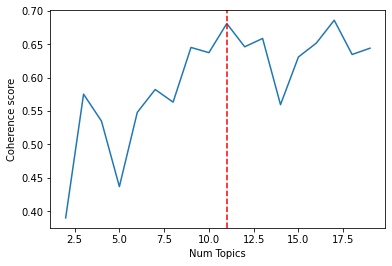

In [21]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.axvline(x = 11, ymin = 0, ymax = 1, color ='red', linestyle="--") 
#plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [278]:
import pyLDAvis
from pyLDAvis import gensim as sim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.178817 -0.290533       1        1  33.510604
6     -0.106840  0.085427       2        1  14.083648
4      0.334179  0.211155       3        1  11.678770
3     -0.099483  0.023148       4        1   9.929690
9     -0.067752  0.061546       5        1   9.090543
1     -0.008066 -0.063990       6        1   6.827535
0     -0.087920  0.034349       7        1   6.349844
5     -0.028628  0.046647       8        1   4.798114
8     -0.059612  0.023614       9        1   1.739657
10    -0.017476 -0.134424      10        1   1.139212
2     -0.037221  0.003060      11        1   0.852384, topic_info=              Term       Freq      Total Category  logprob  loglift
1095          дата  69.000000  69.000000  Default  30.0000  30.0000
1119      документ  55.000000  55.000000  Default  29.0000  29.0000
433       правовой  67.000000  67.000000  Default  28.0000  28.0000
1245  планирование  73.000000  73.000000  Default  27.0000  27.0000
1108        дефект  36.000000  36.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
320           свой   1.805719  18.141476  Topic11  -4.8019   2.4576
1331        проезд   1.844110  23.661948  Topic11  -4.7809   2.2130
1397        сервис   2.077151  44.931366  Topic11  -4.6619   1.6907
1318    проведение   1.843595  28.907022  Topic11  -4.7812   2.0125
10         просьба   1.655240  37.142388  Topic11  -4.8889   1.6541

[583 rows x 6 columns], token_table=      Topic      Freq                                   Term
term                                                        
3267      3  0.920534                                азёрник
326       6  0.967346                         алгоритмизация
327       6  0.967512                алгоритмизация_правовой
328       6  0.968877  алгоритмизация_правовой_сопровождение
1992      5  0.897101                                  альфа
...     ...       ...                                    ...
2703      5  0.898780                                эксперт
2720      5  0.838756                      этаж_переговорный
1498      1  0.974788                           южнопортовый
1501      1  0.961280                    южнопортовый_проезд
3626      3  0.968332                                  юрист

[803 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 5, 4, 10, 2, 1, 6, 9, 11, 3])

{'установка': 0.015, 'меняться': 0.015, 'инструкция': 0.015, 'модель': 0.012, 'указать': 0.012, 'шаблон': 0.012, 'релиз': 0.009, 'сборка': 0.009, 'случай': 0.009, 'развёртывание': 0.009, 'указать_шаблон': 0.009, 'дистрибутив': 0.009, 'шаблон_развёртывание': 0.009, 'просьба': 0.006, 'инструкция_установка': 0.006, 'указать_шаблон_развёртывание': 0.006, 'квота': 0.006, 'писать': 0.006, 'общий': 0.003, 'новый': 0.003, 'добавить': 0.003, 'список': 0.003, 'провести': 0.003, 'должный': 0.003, 'процесс': 0.003, 'снабжать_дистрибутив_модель': 0.003, 'шаблон_развёртывание_добавить': 0.003, 'продолжить_получение_инструкция': 0.003, 'установка_модель': 0.003, 'снабжать_дистрибутив': 0.003, 'неменяться_случай_меняться': 0.003, 'писать_установка_релиз': 0.003, 'предыдущий_релиз_писать': 0.003, 'заменить_прийти': 0.003, 'развёртывание_сборка': 0.003, 'инструкция_учитывать_целое': 0.003, 'развёртывание_меняться': 0.003, 'сборка_просьба_напрямую': 0.003, 'случай_меняться_шаблон': 0.003, 'модель_сборка'

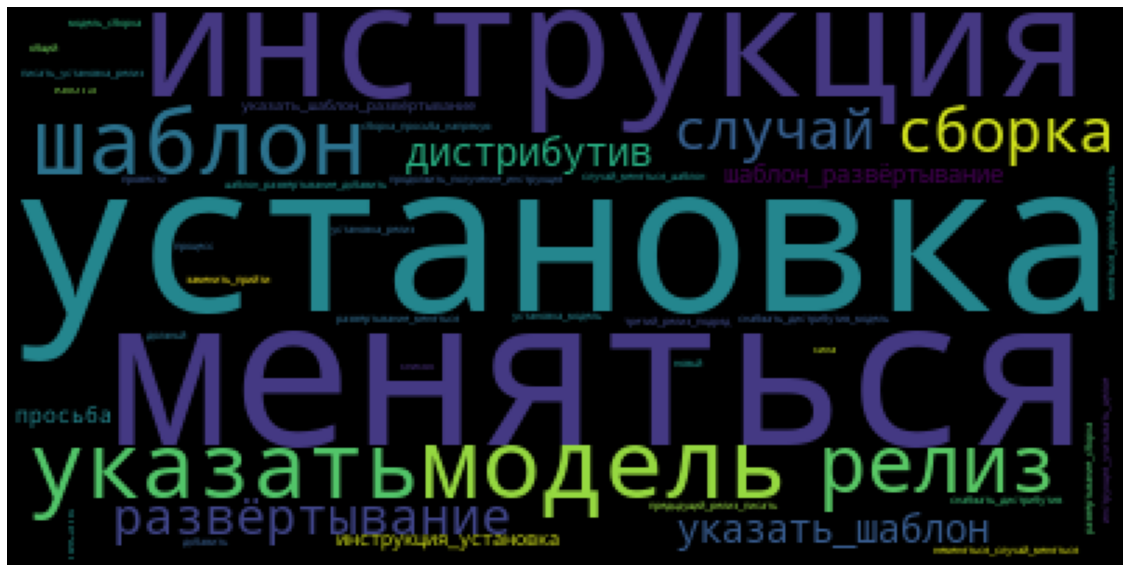

In [23]:
for i in range(0, lda_model.num_topics-1):

  words = [elem.strip().split("*")[1][1:-1] for elem in lda_model.print_topic(i, topn=1000).split("+")]
  weights = [float(elem.strip().split("*")[0]) for elem in lda_model.print_topic(i, topn=1000).split("+")]
  print(dict(zip(words, weights)))

  wc = WordCloud()

  try:
    wc.generate_from_frequencies(dict(zip(words, weights)))
    plt.figure(1,figsize=(20, 20))
    plt.imshow(wc)
    plt.axis('off')
    plt.savefig('wordcloud.png')
    plt.show()
    break
  except:
    pass

In [ ]:
out_json = []

for i, row in enumerate(lda_model.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)):
  dict_ = {}
  dict_["text"] = docs[i]
  topic_id = max(lda_model.get_document_topics(corpus[i]),key=operator.itemgetter(1))[0]
  dict_["topics"] = [term.strip().split("*")[1][1:-1] for term in lda_model.print_topic(topic_id).split("+")]
  out_json.append(dict_)

In [ ]:
len(out_json)

100

In [ ]:
with open("groups.json", "w") as outfile:
  json.dump(out_json, outfile, ensure_ascii=False) 